# eROSITA data analysis of galaxy clusters: multiple-band image fitting

- Contact: Ang Liu (liuang@mpe.mpg.de)

<br>

Measure the properties of Hydra cluster (Abell 1060) by fitting its X-ray images in multiple bands. 

Requirements: 

- eSASS 

  https://erosita.mpe.mpg.de/dr1/eSASS4DR1/eSASS4DR1_installation/

- HEASoft 

  https://heasarc.gsfc.nasa.gov/docs/software/heasoft/

- MBProj2D

  https://github.com/jeremysanders/mbproj2d

<br>

References:

- Sanders et al. (2018), MNRAS, 474, 1065

  https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.1065S/abstract

- Liu et al. (2023), A&A, 670, A96

  https://ui.adsabs.harvard.edu/abs/2023A%26A...670A..96L/abstract

- Bulbul et al. (2024), A&A, 685, A106

  https://ui.adsabs.harvard.edu/abs/2024A%26A...685A.106B/abstract


In [177]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70.0 * u.km / u.s / u.Mpc, Om0=0.3)
import subprocess
# from multiprocessing import Pool
import multiprocess
from astropy.visualization import simple_norm
from scipy.ndimage import gaussian_filter
from astropy import wcs
from astropy.wcs import WCS
from PIL import Image
import h5py
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
import mbproj2d as mb
import corner
from mbproj2d.par import Par, PriorGaussian, PriorBoundedGaussian
from mbproj2d.utils import binImage
import pickle
import os
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

if not os.path.exists("figs"):
    os.mkdir("figs")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("mbproj2d_out"):
    os.mkdir("mbproj2d_out")

In [169]:
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'

## Basic information of Hydra cluster

- Coordinates, redshift: 

https://ned.ipac.caltech.edu/

https://simbad.u-strasbg.fr/simbad/

- Galactic hydrogen column density to compute absorption:

https://www.swift.ac.uk/analysis/nhtot/

https://gdpyc.readthedocs.io/en/latest/

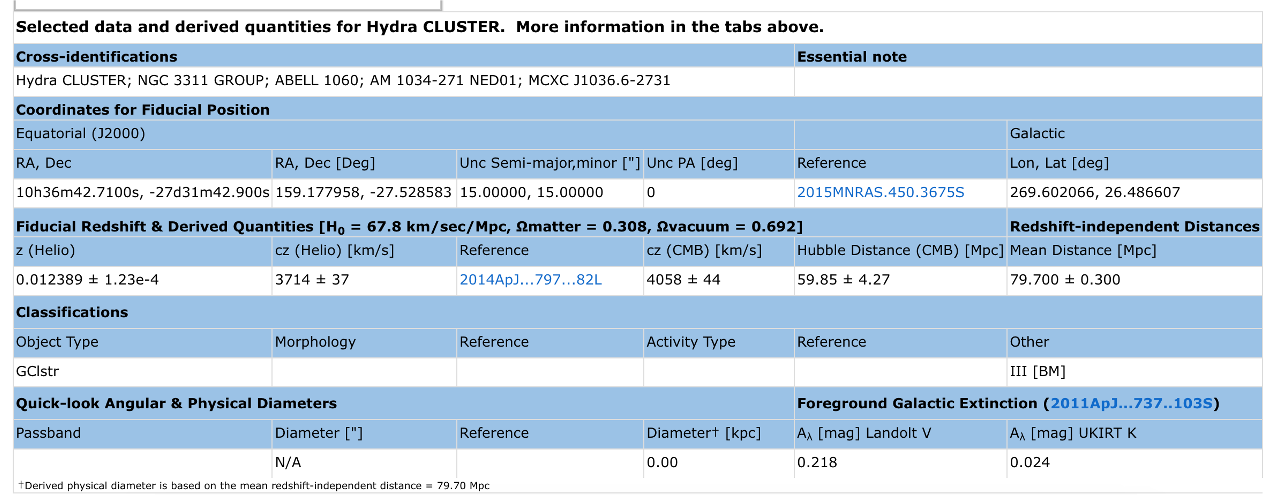

In [2]:
Image("figs/ned.png")

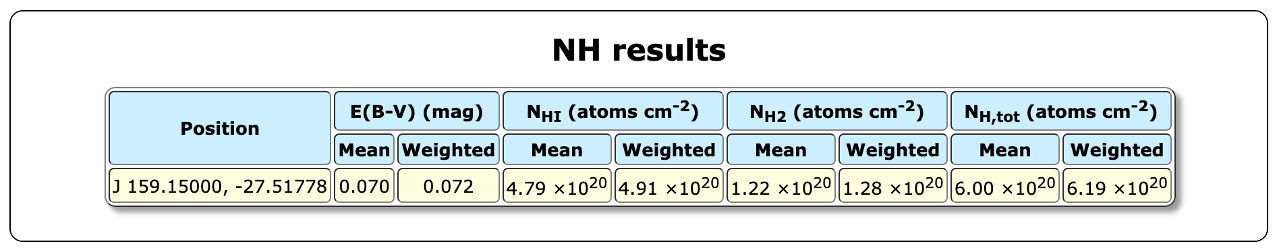

In [3]:
Image("figs/nh.png")

- RA: 159.177958 deg

- Dec: -27.528583 deg

- Redshift: 0.012389

- nH: 0.0619E22 cm-2

In [2]:
ra_hydra = 159.177958
dec_hydra = -27.528583
z_hydra = 0.012389
nh_hydra = 0.0619

## Search and download eROSITA data for Hydra cluster

- https://erosita.mpe.mpg.de/dr1/erodat/skyview/skytile_search/

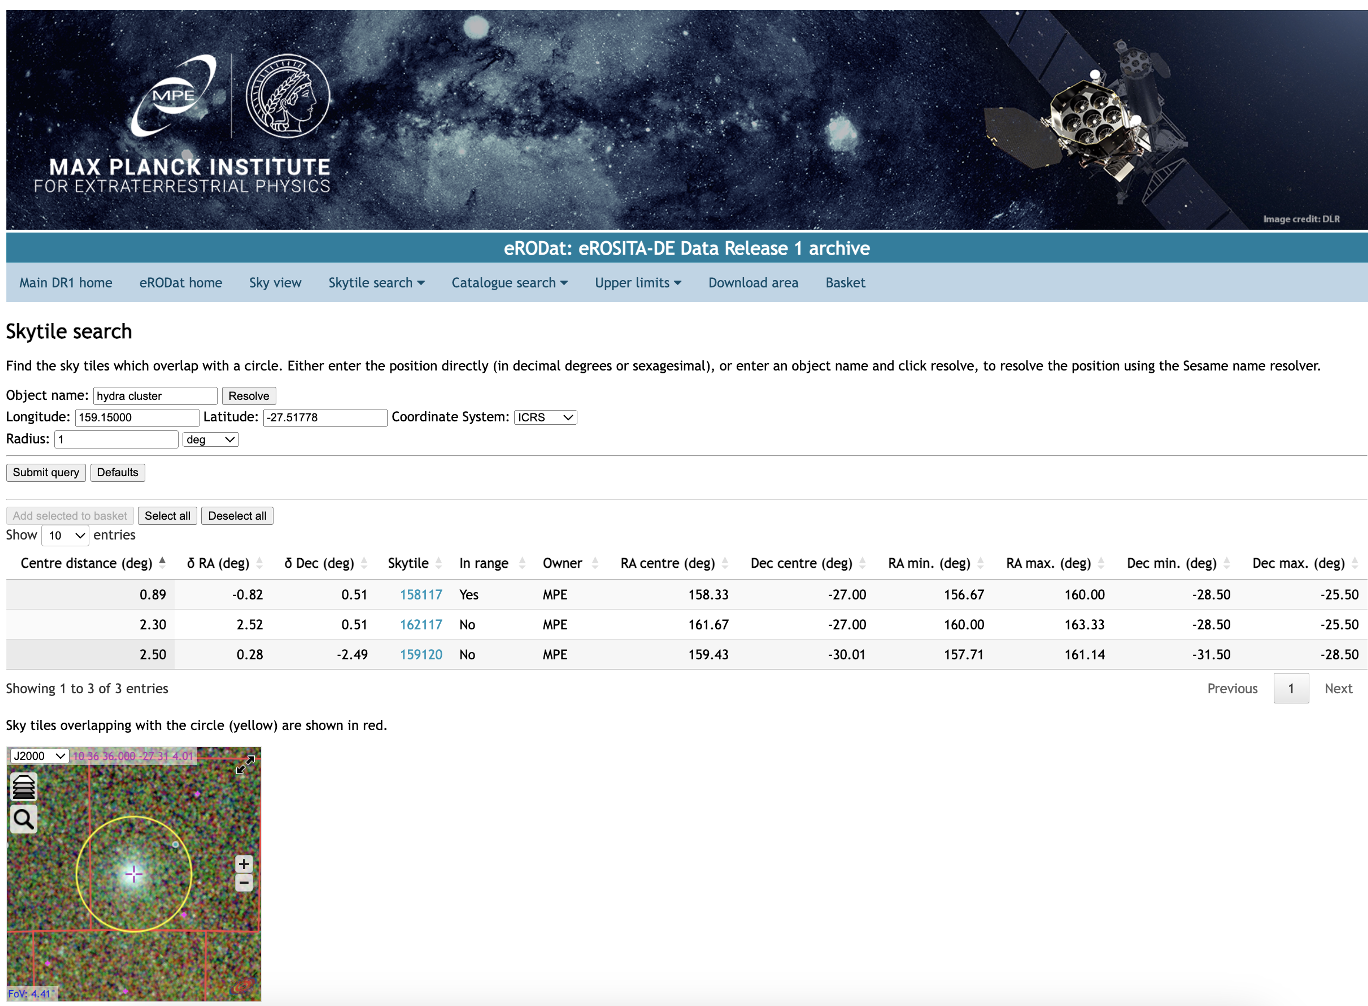

In [5]:
Image("figs/dr1.png")

- Download the event files for these tiles.

In [170]:
# Create a list of the event files
!ls data/*_020_EventList_c010.fits.gz > data/eventfiles.list

In [171]:
!cat data/eventfiles.list

data/em01_158117_020_EventList_c010.fits.gz
data/em01_159120_020_EventList_c010.fits.gz
data/em01_162117_020_EventList_c010.fits.gz


In [172]:
# Create a region file for Hydra cluster
with open('data/hydra.reg', 'w') as f:
    print(f"fk5; circle({ra_hydra},{dec_hydra},1)", file=f)

In [173]:
# Create the event file in hydra.reg and 
subprocess.run(["evtool", 
                "eventfiles=@data/eventfiles.list",
                "outfile=data/evt_hydra.fits",
                "events=yes",
                "image=no",
                "telid=1 2 3 4 6", # Only use telescope modules (TMs) 1,2,3,4,6. TMs 5 and 7 are affected by light leaks
                "region=data/hydra.reg",])

# Reproject the event file to cluster center (optional)
# subprocess.run(["radec2xy", 
#                 "file=evt_hydra.fits",
#                 f"ra0={ra_hydra}",
#                 f"dec0={dec_hydra}"])

 evtool: 2.29.2.3 eSASS4DR1 Nov 11 13:54:27 2024
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 2
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 3
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: Merging infiles.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Update filter settings.
 evtool/evtool_main: Merging extensions.
 evtool/merge_extensions: Merging 3 files.
 evtool/merge_extensions: Infiles will be read 1 extension at a time.
 evtool/del_dup_char_tBinTable: **WARNING1** Number of duplicate rows removed from EVENTS: 107974
 evtool/del_dup_seq_tBinTable: **WARNING1** Number of duplicate rows removed from CORRATT1: 4886
 evtool/del_dup_seq_tBinTable: **WARNING1** Number of duplicate rows removed from CORRATT2: 4884
 evtool/del_dup_seq_tBinTable: **WARNING1** Number of duplicate rows removed from CORRATT3

CompletedProcess(args=['evtool', 'eventfiles=@data/eventfiles.list', 'outfile=data/evt_hydra.fits', 'events=yes', 'image=no', 'telid=1 2 3 4 6', 'region=data/hydra.reg'], returncode=0)

## Create images and exposure maps in three bands (keV): 0.3-1.0, 1.0-2.3, 2.3-7.0

In [174]:
# Compute the center position of the images by converting (ra, dec) to physical pixels
def cen_pos(evt, ra, dec):
    f = fits.open(evt)
    hdu = f['events']
    xcol, ycol = hdu.data.columns['X'], hdu.data.columns['Y']
    w = WCS(naxis=2)
    w.wcs.crpix = [xcol.coord_ref_point, ycol.coord_ref_point]
    w.wcs.cdelt = [xcol.coord_inc, ycol.coord_inc]
    w.wcs.crval = [xcol.coord_ref_value, ycol.coord_ref_value]
    w.wcs.ctype = [xcol.coord_type, ycol.coord_type]
    xval, yval = w.wcs_world2pix(ra, dec, 1)  # count from 1, not 0
    return xval, yval

xcen, ycen = cen_pos("data/evt_hydra.fits", ra_hydra, dec_hydra)
print(xcen, ycen)

-53925.82075986794 -37889.59659404502


In [175]:
bands = [(300, 1000), (1000, 2300), (2300, 7000), (200, 2300),] 

def mkimg(band):
    bandname = '%.1f_%.1f' % (band[0] / 1000, band[1] / 1000)
    subprocess.run(["evtool", 
            "eventfiles=data/evt_hydra.fits",
            f"outfile=data/ima_{bandname}.fits.gz",
            "events=no",
            "image=yes",
            f"emin={band[0] / 1000 :.1f}",
            f"emax={band[1] / 1000 :.1f}",
            "rebin=80", # pixelsize = 4arcsec * rebin / 80
            "size=1800", # 2deg * 3600 / pixelsize
            f"center_position={xcen :.2f} {ycen :.2f}",
            "region=data/hydra.reg",])
    
def mkexpmap(band):
    bandname = '%.1f_%.1f' % (band[0] / 1000, band[1] / 1000)
    subprocess.run(["expmap", 
            "inputdatasets=data/evt_hydra.fits",
            f"templateimage=data/ima_{bandname}.fits.gz",
            f"mergedmaps=data/exp_{bandname}.fits.gz",
            f"emin={band[0] / 1000 :.1f}",
            f"emax={band[1] / 1000 :.1f}",
            "withsinglemaps=no", 
            "withmergedmaps=yes", # Only create merged exposure map
            "withdetmaps=yes", # Ignore CCD corners when computing exposure time
            "withvignetting=yes",]) # Correct for vignetting effect

In [176]:
with multiprocess.Pool() as pool:
    pool.map(mkimg, bands)
    pool.map(mkexpmap, bands)

 evtool: 2.29.2.3 eSASS4DR1 Nov 11 13:54:27 2024
 evtool: 2.29.2.3 eSASS4DR1 Nov 11 13:54:27 2024
 evtool: 2.29.2.3 eSASS4DR1 Nov 11 13:54:27 2024
 evtool: 2.29.2.3 eSASS4DR1 Nov 11 13:54:27 2024
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Update filter settings.

## Make a mask map to exclude point sources

In [210]:
ima_file = 'data/ima_1.0_2.3.fits.gz'
mask_file = 'data/mask.fits.gz'
pts_cat = 'data/eRASS1_Main.v1.1_hydra.fits.gz'

hdulist = fits.open(ima_file)
ima = hdulist[0].data
prihdr = hdulist[0].header
pix2deg = prihdr['CDELT2'] # deg
xsize, ysize = ima.shape
mask = np.copy(ima) * 0 + 1.

ima_wcs = wcs.WCS(prihdr, relax=False)
ima_racen = ima_wcs.pixel_to_world(ysize / 2 + 0.5, xsize / 2 + 0.5).ra.deg
ima_deccen = ima_wcs.pixel_to_world(ysize / 2 + 0.5, xsize / 2 + 0.5).dec.deg
ima_r = np.max((xsize,ysize)) / 2 * pix2deg # deg
ima_coord = SkyCoord(ima_racen * u.deg, ima_deccen * u.deg, frame = 'icrs')

cat_src = fits.open(pts_cat)[1].data
cat_src = cat_src[(cat_src.EXT == 0) & (cat_src.DET_LIKE_0 > 8)] # Select high S/N point sources with DET_LIKE>8
coord_src = SkyCoord(cat_src.RA * u.deg, cat_src.DEC * u.deg, frame = 'icrs')
sep = ima_coord.separation(coord_src).to(u.deg).value
cat_src = cat_src[sep < ima_r + 1/60] # Select sources within the image

ra_src = cat_src.RA
dec_src = cat_src.DEC

# Fix the masking radius to 1arcmin. Needs to be modified for more accurate analysis.
ext_src = np.zeros(len(ra_src)) + 1/60 

def circle(X, Y):
    x, y = np.meshgrid(X, Y)
    rho = np.sqrt(x * x + y * y)
    return rho

x = np.arange(ysize)
y = np.arange(xsize)
for j in range(len(ra_src)):
    pixim = ima_wcs.all_world2pix([[float(ra_src[j]), float(dec_src[j])]], 0)
    xp = pixim[0][0]
    yp = pixim[0][1]
    rho = circle(x - xp, y - yp) * pix2deg
    ii = np.where(rho <= ext_src[j])
    if len(ii) > 0:
        mask[ii] = 0

# Mask corners
pixcen = ima_wcs.all_world2pix([[ima_racen, ima_deccen]], 0)
xp = pixcen[0][0]
yp = pixcen[0][1]
rho = circle(x - xp, y - yp) * pix2deg
ii = np.where(rho > ima_r)
mask[ii] = 0

hdu = fits.PrimaryHDU(mask)
hdu.header.update(ima_wcs.to_header())
hdulist = fits.HDUList([hdu])
hdulist.writeto(mask_file, overwrite=True)

## Check the images and mask maps (can also be done with ds9)

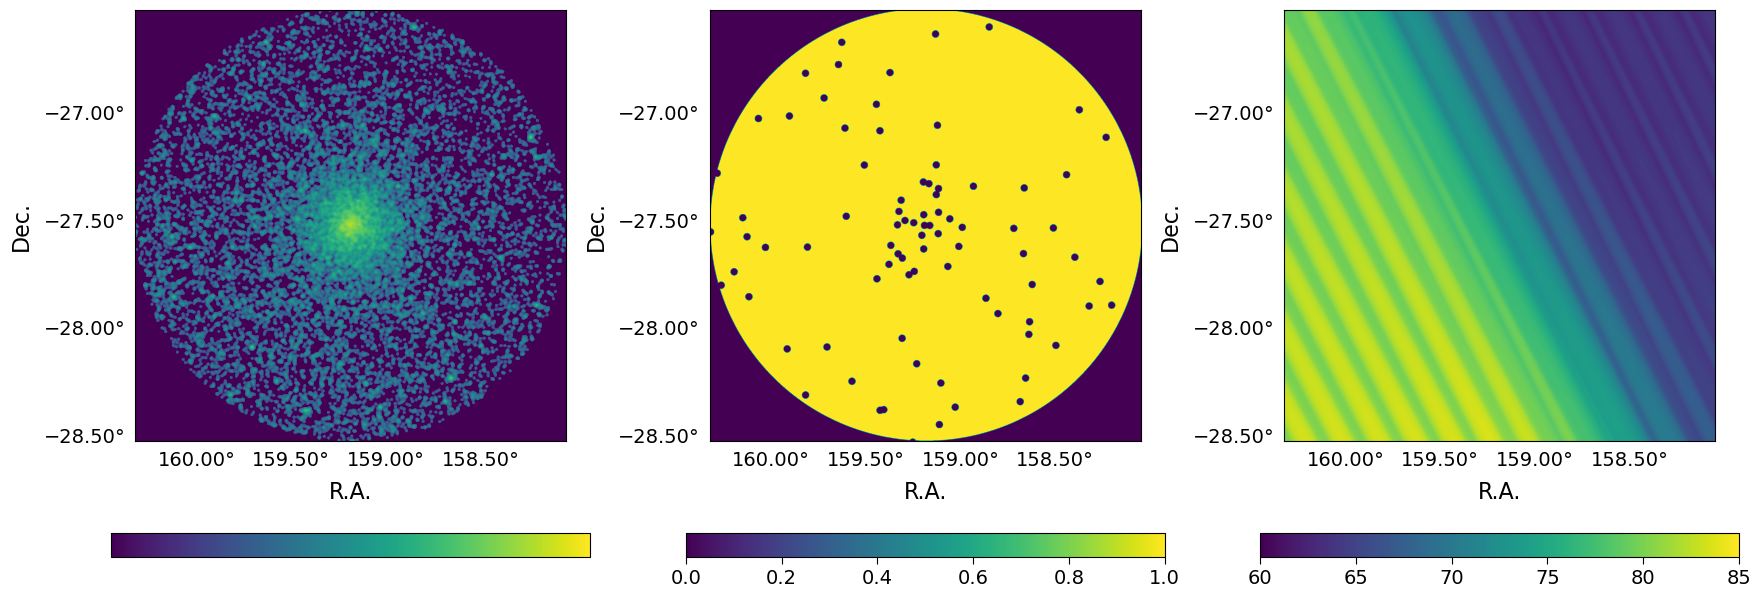

In [211]:
fig = plt.figure(figsize=(21, 8))

mask_file = 'data/mask.fits.gz'
hdulist = fits.open(mask_file)
mask = hdulist[0].data
prihdr = hdulist[0].header
ima_wcs = wcs.WCS(prihdr, relax=False)

exp_file = 'data/exp_1.0_2.3.fits.gz'
hdulist = fits.open(exp_file)
exp = hdulist[0].data

ima_full = np.copy(mask) * 0.0
for i in range(len(bands)):
    bandname = '%.1f_%.1f' % (bands[i][0] / 1000, bands[i][1] / 1000)
    image = f"data/ima_{bandname}.fits.gz"
    hdulist = fits.open(image)
    ima_full += hdulist[0].data

ima_full = ima_full.astype(np.float64)
ima_full = gaussian_filter(ima_full, sigma=5)

ax = fig.add_subplot(131, projection=ima_wcs)
# norm = simple_norm(ima_full, 'log', min_cut=2e-3, max_cut=0.5)
norm = simple_norm(ima_full, 'log', vmin=2e-3, vmax=0.5)
im = plt.imshow(ima_full, norm=norm, cmap=plt.get_cmap('viridis'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=16)
axisdec.set_axislabel('Dec.', fontsize=16)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=14)
im.axes.tick_params(color='white', labelcolor='black')
cbar = plt.colorbar(im, location='bottom', orientation="horizontal", ticks=[])
cbar.ax.tick_params(labelsize=14, length=5)

ax = fig.add_subplot(132, projection=ima_wcs)
# norm = simple_norm(mask, 'linear', min_cut=0, max_cut=1)
norm = simple_norm(mask, 'linear', vmin=0, vmax=1)
im = plt.imshow(mask, norm=norm, cmap=plt.get_cmap('viridis'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=16)
axisdec.set_axislabel('Dec.', fontsize=16)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=14)
im.axes.tick_params(color='white', labelcolor='black')
cbar = plt.colorbar(im, location='bottom', orientation="horizontal")
cbar.ax.tick_params(labelsize=14, length=5)

ax = fig.add_subplot(133, projection=ima_wcs)
# norm = simple_norm(exp, 'linear', min_cut=60, max_cut=85)
norm = simple_norm(exp, 'linear', vmin=60, vmax=85)
im = plt.imshow(exp, norm=norm, cmap=plt.get_cmap('viridis'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=16)
axisdec.set_axislabel('Dec.', fontsize=16)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=14)
im.axes.tick_params(color='white', labelcolor='black')
cbar = plt.colorbar(im, location='bottom', orientation="horizontal")
cbar.ax.tick_params(labelsize=14, length=5)


- We can also convert the source regions into ds9 region files, and inspect them using ds9

In [214]:
with open('data/sources.reg', 'w') as f:
    for i in range(len(ra_src)):
        print(f"fk5; circle({ra_src[i]},{dec_src[i]},{ext_src[i]})", file=f)

- ds9 data/ima_0.2_2.3.fits.gz -region load data/sources.reg -scale log -smooth yes -zoom to fit &

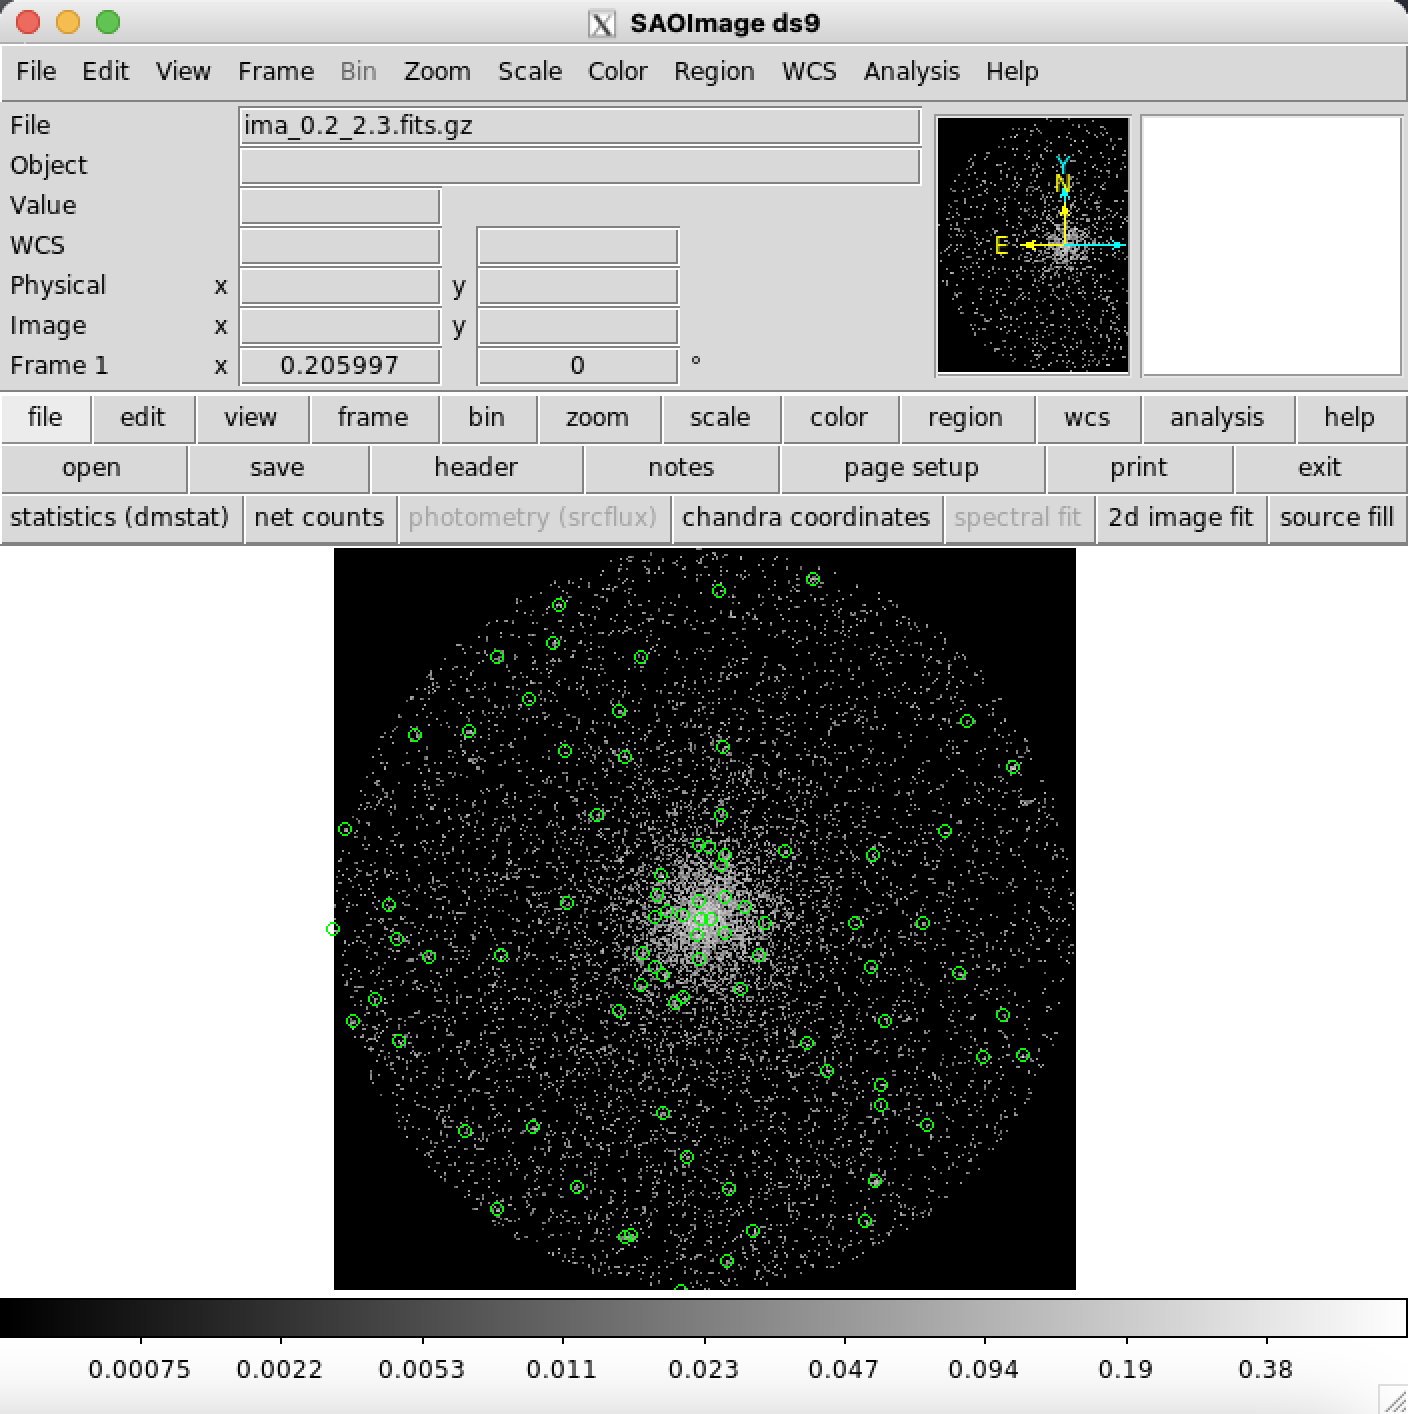

In [216]:
Image("figs/ds9.png")

- Edit and save the new regions

In [217]:
!cat data/sources_edit.reg

# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(159.1998084,-27.5761205,60.000")
circle(158.2379000,-27.1250200,166.267")
circle(158.2081915,-27.9020768,60.000")
circle(159.1892518,-27.4806878,60.000")
circle(158.6599346,-28.2393833,60.000")
circle(159.1119676,-27.4701593,60.000")
circle(159.4263513,-28.3847672,60.000")
circle(159.4068468,-28.3820252,60.000")
circle(159.3183963,-27.4648643,60.000")
circle(159.1907140,-27.6392849,60.000")
circle(159.3066397,-27.4128561,60.000")
circle(159.7018257,-28.0893509,60.000")
circle(158.8040669,-27.9403273,60.000")
circle(159.4140271,-27.0905186,60.000")
circle(159.8838370,-27.0179000,60.000")
circle(158.6887092,-28.3483218,60.000")
circle(159.0070935,-27.6284807,60.000")
circle(159.0533458,-27.5007416,60.000")
circle(159.2417620,-27.5176306,60.000")
circle(159.6079030,-26.6794675,60.000")
circle(

- make a new mask map using the new region file

In [222]:
ima_file = 'data/ima_1.0_2.3.fits.gz'
mask_file = 'data/mask_new.fits.gz'
reg_file = 'data/sources_edit.reg'

hdulist = fits.open(ima_file)
ima = hdulist[0].data
prihdr = hdulist[0].header
pix2deg = prihdr['CDELT2'] # deg
xsize, ysize = ima.shape
mask = np.copy(ima) * 0 + 1.

ima_wcs = wcs.WCS(prihdr, relax=False)
ima_racen = ima_wcs.pixel_to_world(ysize / 2 + 0.5, xsize / 2 + 0.5).ra.deg
ima_deccen = ima_wcs.pixel_to_world(ysize / 2 + 0.5, xsize / 2 + 0.5).dec.deg
ima_r = np.max((xsize,ysize)) / 2 * pix2deg # deg

reg = open(reg_file).readlines()
ra_src = []
dec_src = []
ext_src = []
for i in range(len(reg)):
    if 'circle(' in reg[i]:
        ra_src.append(float(reg[i].split(",")[0].strip('circle(')))
        dec_src.append(float(reg[i].split(",")[1].strip('')))
        ext_src.append(float(reg[i].split(",")[2].split("\"")[0])/3600)

def circle(X, Y):
    x, y = np.meshgrid(X, Y)
    rho = np.sqrt(x * x + y * y)
    return rho

x = np.arange(ysize)
y = np.arange(xsize)
for j in range(len(ra_src)):
    pixim = ima_wcs.all_world2pix([[float(ra_src[j]), float(dec_src[j])]], 0)
    xp = pixim[0][0]
    yp = pixim[0][1]
    rho = circle(x - xp, y - yp) * pix2deg
    ii = np.where(rho <= ext_src[j])
    if len(ii) > 0:
        mask[ii] = 0
        
# Mask corners
pixcen = ima_wcs.all_world2pix([[ima_racen, ima_deccen]], 0)
xp = pixcen[0][0]
yp = pixcen[0][1]
rho = circle(x - xp, y - yp) * pix2deg
ii = np.where(rho > ima_r)
mask[ii] = 0

hdu = fits.PrimaryHDU(mask)
hdu.header.update(ima_wcs.to_header())
hdulist = fits.HDUList([hdu])
hdulist.writeto(mask_file, overwrite=True)

## Fit the images with MBProj2D

In [181]:
# input cluster parameters
cl_ra = [159.177958, ]
cl_dec = [-27.528583, ]
cl_radec_err = [60, ]
cl_z = [0.012389, ]
cl_idx = [1, ]
NH_1022pcm2 = 0.0619
imagebin = 4 # bin the images to converge faster

bands = [(300, 1000), (1000, 2300), (2300, 7000),]

- Download PSF file: https://erosita.mpe.mpg.de/dr1/eSASS4DR1/eSASS4DR1_CALDB/
- /Path to your eSASS CALDB/data/erosita/tm1/bcf/tm1_2dpsf_190220v03.fits

In [182]:
# psf is energy-dependent. Check which bands to use.
psf_fname = 'data/tm1_2dpsf_190220v03.fits'

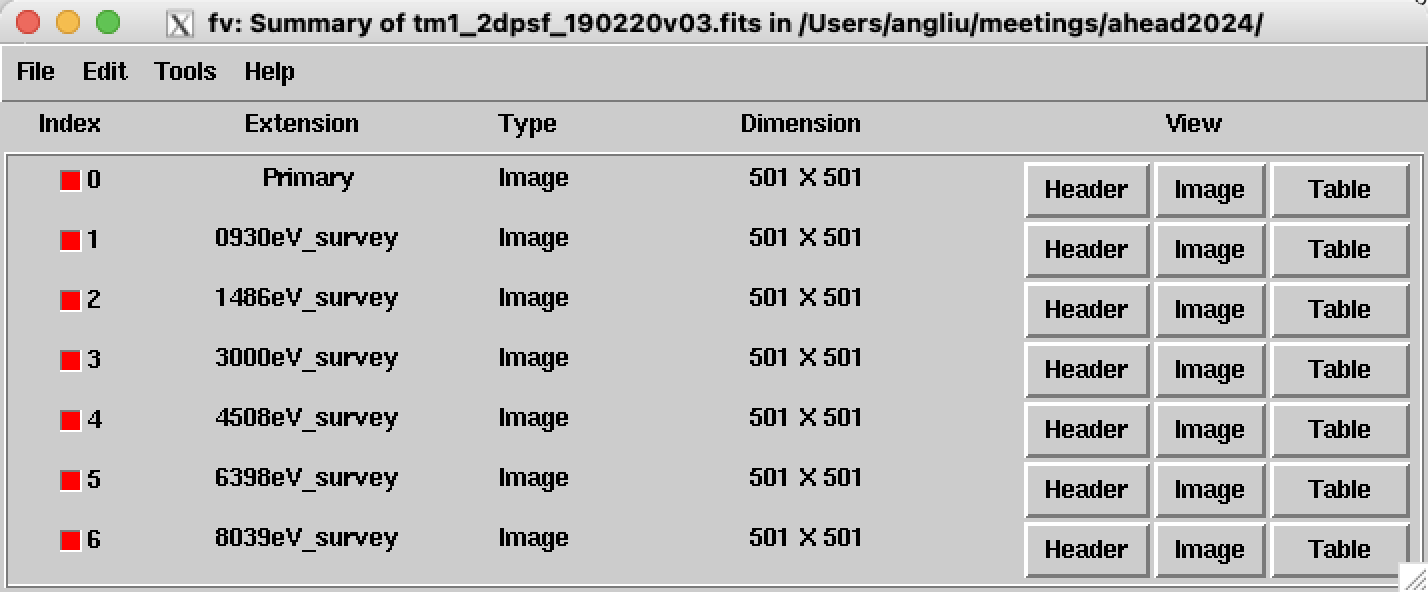

In [183]:
Image("figs/psf.png")

In [184]:
bandPSFHDUs = [1, 2, 4,]

- Download RMF and ARF files: https://erosita.mpe.mpg.de/dr1/eSASS4DR1/eSASS4DR1_arfrmf/

In [185]:
rmf_onaxis = 'data/onaxis_tm0_rmf_2023-01-17.fits.gz'
arf_onaxis = 'data/onaxis_tm8_arf_filter_2023-01-17.fits.gz'

- Load image, exposure map and PSF for each band

In [186]:
images = []
for band, psfhdu in zip(bands, bandPSFHDUs):
    print('Loading', band)

    bandname = '%.1f_%.1f' % (band[0] / 1000, band[1] / 1000)
    maskfile = 'data/mask.fits.gz'
    img = mb.imageLoad(
        'data/ima_%s.fits.gz' % (bandname),
        'data/exp_%s.fits.gz' % (bandname),
        rmf=rmf_onaxis, arf=arf_onaxis,
        emin_keV=band[0] / 1000, emax_keV=band[1] / 1000,
        mask_fname=maskfile,
        pix_origin=(0, 0),
        psf=mb.PSFLoad(psf_fname, psfhdu),
        pad=64,  # pad image sizes to ensure convolution doesn’t wrap
    )

    if imagebin > 1:
        newimg = img.binUp(imagebin)
        images.append(newimg)
    else:
        images.append(img)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59000.900914 from DATE-OBS.
Set MJD-END to 59004.568229 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59000.900914 from DATE-OBS.
Set MJD-END to 59004.568229 from DATE-END'.


Loading (300, 1000)
Loading (1000, 2300)
Loading (2300, 7000)


In [187]:
# Output files of MBProj2D
parfname = "mbproj2d_out/mbproj2d_pars.pickle"
chainfname = "mbproj2d_out/mbproj2d_chain.hdf5"
physfname = "mbproj2d_out/mbproj2d_phys.hdf5"
modimgfname = "mbproj2d_out/mbproj2d_img.fits"
sbfname = "mbproj2d_out/mbproj2d_sb.hdf5"

In [188]:
# initial parameters
pars = mb.Pars()

# metallicity profile (flat, fixed)
Z_prof = mb.ProfileFlat('Z', pars, defval=0.4)
pars['Z'].frozen = True

cluster_cmpts = []
for idx, ra, dec, radec_err, z in zip(cl_idx, cl_ra, cl_dec, cl_radec_err, cl_z):
    xpos, ypos = images[0].wcs.all_world2pix(ra, dec, 0)

    # cosmology
    cosmo = mb.Cosmology(z, H0=70.0, q0=0.5, WM=0.3, WV=0.7)

    # temperature profile (flat, in ln T)
    T_prof = mb.ProfileFlat(
        'T_log_%i' % idx, pars,
        defval=math.log(3),
        log=True,
        minval=math.log(0.1),
        maxval=math.log(10)
    )

    # # A more complicated temperature profile with 8 free parameters:
    # # https://mbproj2d.readthedocs.io/en/latest/_modules/mbproj2d/profile.html#ProfileMcDonaldT
    # T_prof = mb.ProfileMcDonaldT(
    #     'T_log_%i' % idx, pars,
    # )

    # density profile (single beta-model, 3 free parameters)
    ne_prof = mb.ProfileBeta('ne_%i' % idx, pars)

    # # density profile (single beta-component Vikhlinin model, 6 free parameters)
    # # https://mbproj2d.readthedocs.io/en/latest/_modules/mbproj2d/profile.html#ProfileVikhDensity
    # ne_prof = mb.ProfileVikhDensity('ne_%i' % idx, pars, mode='single')

    # non-hydrostatic model
    cluster = mb.ClusterNonHydro(
        'cl_%i' % idx,  # name
        pars,
        images,
        cosmo=cosmo,
        NH_1022pcm2=NH_1022pcm2,
        ne_prof=ne_prof,
        T_prof=T_prof,
        Z_prof=Z_prof,
    )
    
    # Note: positions are relative to the origin of the input images, and are in arcsec
    fix_cen = True # Fix cluster center. Thaw it to fit cluster center with the given prior
    xp = pars['cl_%i_cx' % idx]
    xp.val = xpos * images[0].pixsize_as
    xp.prior = mb.PriorBoundedGaussian(xpos * images[0].pixsize_as, radec_err,
                                       minval=xpos * images[0].pixsize_as - 60,
                                       maxval=xpos * images[0].pixsize_as + 60
                                       )
    xp.frozen = fix_cen 
    yp = pars['cl_%i_cy' % idx]
    yp.val = ypos * images[0].pixsize_as
    yp.prior = mb.PriorBoundedGaussian(ypos * images[0].pixsize_as, radec_err,
                                       minval=ypos * images[0].pixsize_as - 60,
                                       maxval=ypos * images[0].pixsize_as + 60
                                       )
    yp.frozen = fix_cen

    cluster_cmpts.append(cluster)

In [189]:
# flat background model in each band
backmodel = mb.BackModelFlat(
    'bg', pars, images, log=True, defval=-15, normarea=True,
    expmap='expmap')

for band in bands:
    bandname = '%.1f_%.1f' % (band[0] / 1000, band[1] / 1000)
    bandname = bandname.replace('.0', '')
    pars[f'bg_{bandname}'] = Par(val=-15, minval=-20, frozen=False)

# combine source models and background models to make total model
totmod = mb.TotalModel(
    pars,
    images,
    src_expmap='expmap',
    src_models=cluster_cmpts,
    back_models=[backmodel],
)

In [190]:
fit = mb.Fit(images, totmod, pars)

In [191]:
# load initial parameters if saved
if os.path.exists(parfname):
    print('loading', parfname)
    pars.load(parfname)
else:
    # find best fitting parameters
    pars.write()
    fit.run(maxloops=1)
    pars.write()
    # save parameters
    pars.save(parfname)

         T_log_1:      1.09861 thawed <PriorFlat: minval=-2.3025850929940455, maxval=2.302585092994046>
               Z:          0.4 frozen          <PriorFlat: minval=-inf, maxval=inf>
        bg_0.3_1:          -15 thawed           <PriorFlat: minval=-20, maxval=inf>
        bg_1_2.3:          -15 thawed           <PriorFlat: minval=-20, maxval=inf>
        bg_2.3_7:          -15 thawed           <PriorFlat: minval=-20, maxval=inf>
        bg_scale:            1 frozen           <PriorGaussian: mu=1.0, sigma=0.05>
         cl_1_cx:         3592 frozen <PriorBoundedGaussian: mu=3592.0000155313414, sigma=60, minval=3532.0000155313414, maxval=3652.0000155313414>
         cl_1_cy:         3592 frozen <PriorBoundedGaussian: mu=3592.0002238225047, sigma=60, minval=3532.0002238225047, maxval=3652.0002238225047>
       ne_1_beta:     0.666667 thawed           <PriorFlat: minval=0.0, maxval=4.0>
      ne_1_logn0:     -6.90776 thawed         <PriorFlat: minval=-14.0, maxval=5.0>
      ne_1_l

    -55027.5     -7.94977      1.15899     -13.5652       -14.24     -13.4692     0.686409      -5.2989      4.64019
    -55027.5     -7.94977      1.15899     -13.5652       -14.24     -13.4692     0.686409      -5.2989      4.63799
    -55027.5     -7.94977      1.15899     -13.5652     -14.2369     -13.4692     0.686409      -5.2989      4.63854
    -55027.4     -7.94977      1.15899     -13.5652     -14.2338     -13.4692     0.686004      -5.2989      4.63835
    -55027.4     -7.94977      1.15806     -13.5652     -14.2338     -13.4692     0.685599      -5.2989      4.63835
    -55027.3     -7.94977      1.15759     -13.5652     -14.2338     -13.4692     0.685194      -5.2989      4.63835
    -55027.3     -7.94977      1.15876     -13.5652     -14.2338     -13.4692     0.684789      -5.2989      4.63835
    -55027.3     -7.94977      1.17061     -13.5652     -14.2338     -13.4692     0.684493     -5.30274      4.63835
    -55027.3     -7.94977      1.17061     -13.5682     -14.2338

    -55025.4     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505      -5.2895      4.61426
    -55025.3     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505      -5.2839      4.61132
    -55025.2     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505     -5.27605      4.60621
    -55025.2     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505     -5.27283      4.60341
    -55025.1     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505     -5.27101       4.6001
    -55025.1     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673505     -5.26364      4.59507
      -55025     -7.94977      1.15831     -13.5757      -14.254     -13.4707     0.673034     -5.26364      4.59507
    -55024.9     -7.94977      1.15831     -13.5757      -14.254     -13.4743     0.672562     -5.26364      4.59507
    -55024.9     -7.94977      1.15831     -13.5757      -14.254

In [192]:
# writes the best-fitting model as a 3D fits file (one slice per band)
img_3d = np.array(totmod.compute(pars))
hdulist = fits.HDUList(fits.PrimaryHDU(img_3d))
hdulist.writeto(modimgfname, overwrite=True)

In [197]:
# do MCMC on parameters. The output is written to a HDF5 fits
# containing the chain values and likelihoods
print("Starting MCMC")
nprocesses = 8
nwalkers = 3 * pars.numFree()
if nwalkers % 2 != 0:
    nwalkers += 1  # make even
if nwalkers < 50:
    nwalkers = 50

# allowing extending the chain, periodic saving and restarting later
nburn, nrun = 500, 3000
nsteps = nrun + nburn
mcmc = mb.MCMCSamplerEmcee(fit, nwalkers, nprocesses=nprocesses)
nsampled = mcmc.sample(
    mb.MCMCStoreHDF5(chainfname, pars, nwalkers, flush_time=60, nburn=nburn), # save the chain every 60sec
    nsteps=nsteps,
)

Starting MCMC


100%|███████████████████████████████████████████████████████████████| 3500/3500 [10:53<00:00,  5.35it/s]


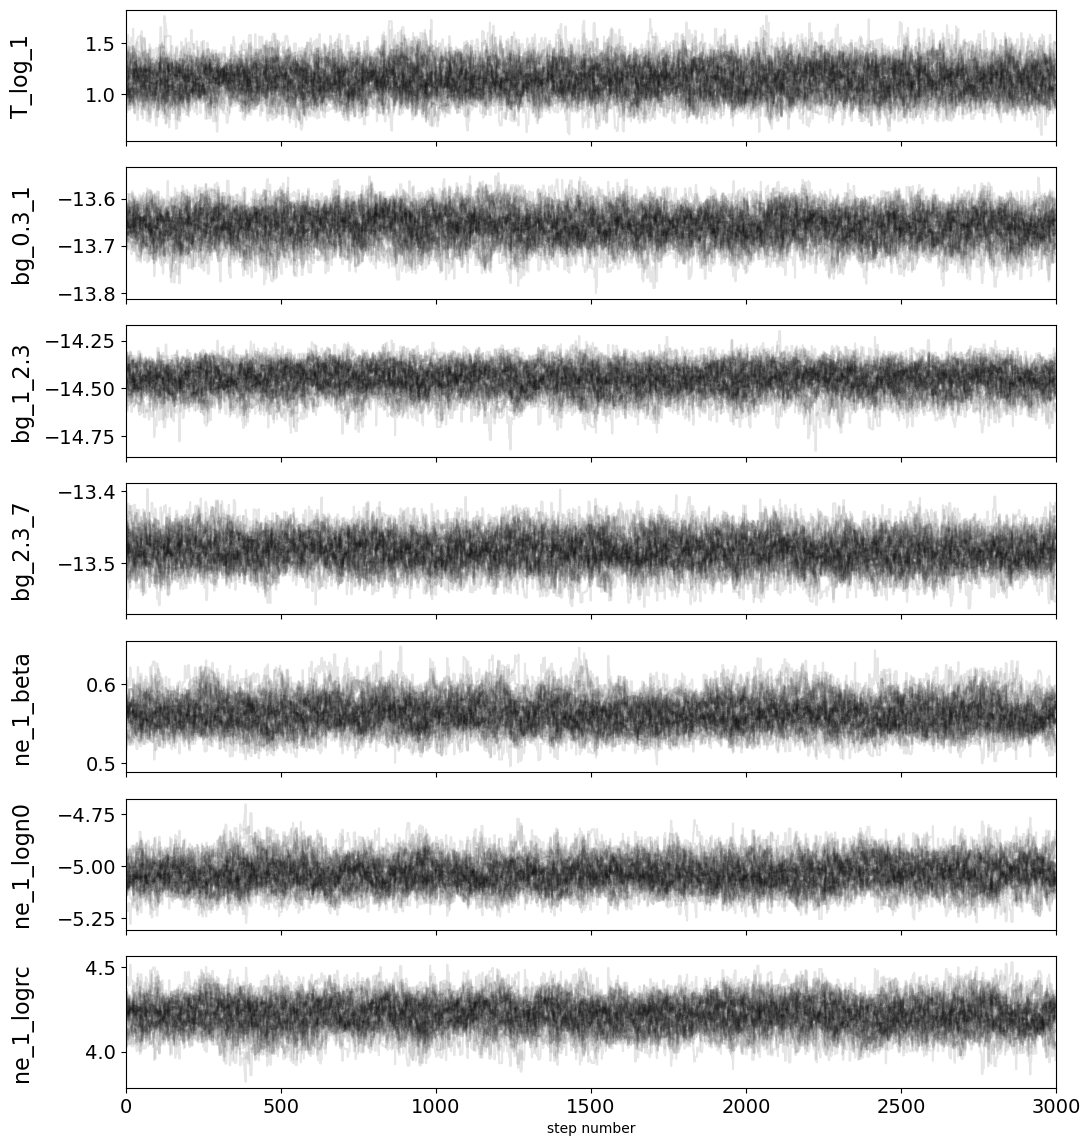

In [198]:
# Check convergence
chain = h5py.File(chainfname, 'r')
par_names = chain['thawed_params'][:].astype(str)
data_mcmc = np.swapaxes(chain['chain'], 0, 1)
flat_data_mcmc = data_mcmc.reshape((-1, len(par_names)))

fig, axes = plt.subplots(len(par_names), figsize=(12, 2 * len(par_names)), sharex=True)
for i in range(len(par_names)):
    ax = axes[i]
    ax.plot(data_mcmc[:, :, i].T, "k", alpha=0.1)
    ax.set_xlim(0, len(data_mcmc[:, :, 0].T))
    ax.set_ylabel(par_names[i], fontsize=16)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=14)

axes[-1].set_xlabel("step number")
fig.savefig("figs/traceplot.png")

In [199]:
# get profile and residuals
sbmaps = mb.SBMaps(
    pars, totmod, images,
    prof_origin=(pars['cl_1_cy'].v, pars['cl_1_cx'].v),
    make_cvtmaps=False
)

output = sbmaps.calcStats(
    mb.loadChainFromFile(chainfname, pars, burn=500, randsamples=1000),
    h5fname=sbfname,
)

# compute physical quantities
cluster0 = cluster_cmpts[0]

# convert chain to physical profiles
phys = mb.Phys(pars, cluster0, rsteps=512, rmax_kpc=3000,
               rate_rmf=images[0].rmf, rate_arf=images[0].arf,
               fluxrange_keV=((0.2, 2.3), (0.1, 2.4), ), 
               luminrange_keV=((0.2, 2.3), (0.1, 2.4), ),
               rate_bands=((0.2, 2.3), (0.1, 2.4), ))
                # Compute quantities in two bands: 0.2-2.3keV and 0.1-2.4keV

# Take 1000 random samples from the chain and calculate the median physical profiles and 1-sigma range.
# The output file is a HDF5 with a set of profiles (each profile is stored as 2D to include the 1-sigma range)
phys.chainFileToStatsFile(
    chainfname,
    physfname,
    burn=500, randsamples=1000
)

SBMaps: Constructing profile binning
SBMaps: Calculating surface brightness stats
SBMaps:  0/1000
SBMaps:  100/1000
SBMaps:  200/1000
SBMaps:  300/1000
SBMaps:  400/1000
SBMaps:  500/1000
SBMaps:  600/1000
SBMaps:  700/1000
SBMaps:  800/1000
SBMaps:  900/1000
SBMaps:  calculating statistics
SBMaps:  writing to mbproj2d_out/mbproj2d_sb.hdf5
SBMaps: Done
Computing physical quantities from chain
 Step 0 / 1000 (0.0%)


/Users/angliu/anaconda3/lib/python3.12/site-packages/mbproj2d/phys.py:256: RuntimeWarning: divide by zero encountered in divide
  v['fgas_cuml'] = v['Mgas_cuml_Msun'] / v['Mtot_cuml_Msun']
/Users/angliu/anaconda3/lib/python3.12/site-packages/mbproj2d/phys.py:259: RuntimeWarning: divide by zero encountered in divide
  v['tff_yr'] = N.sqrt(3*N.pi/32/G_cgs/rho_gpcm3) / yr_s


 Computing medians


/Users/angliu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


## Inspect fitting results

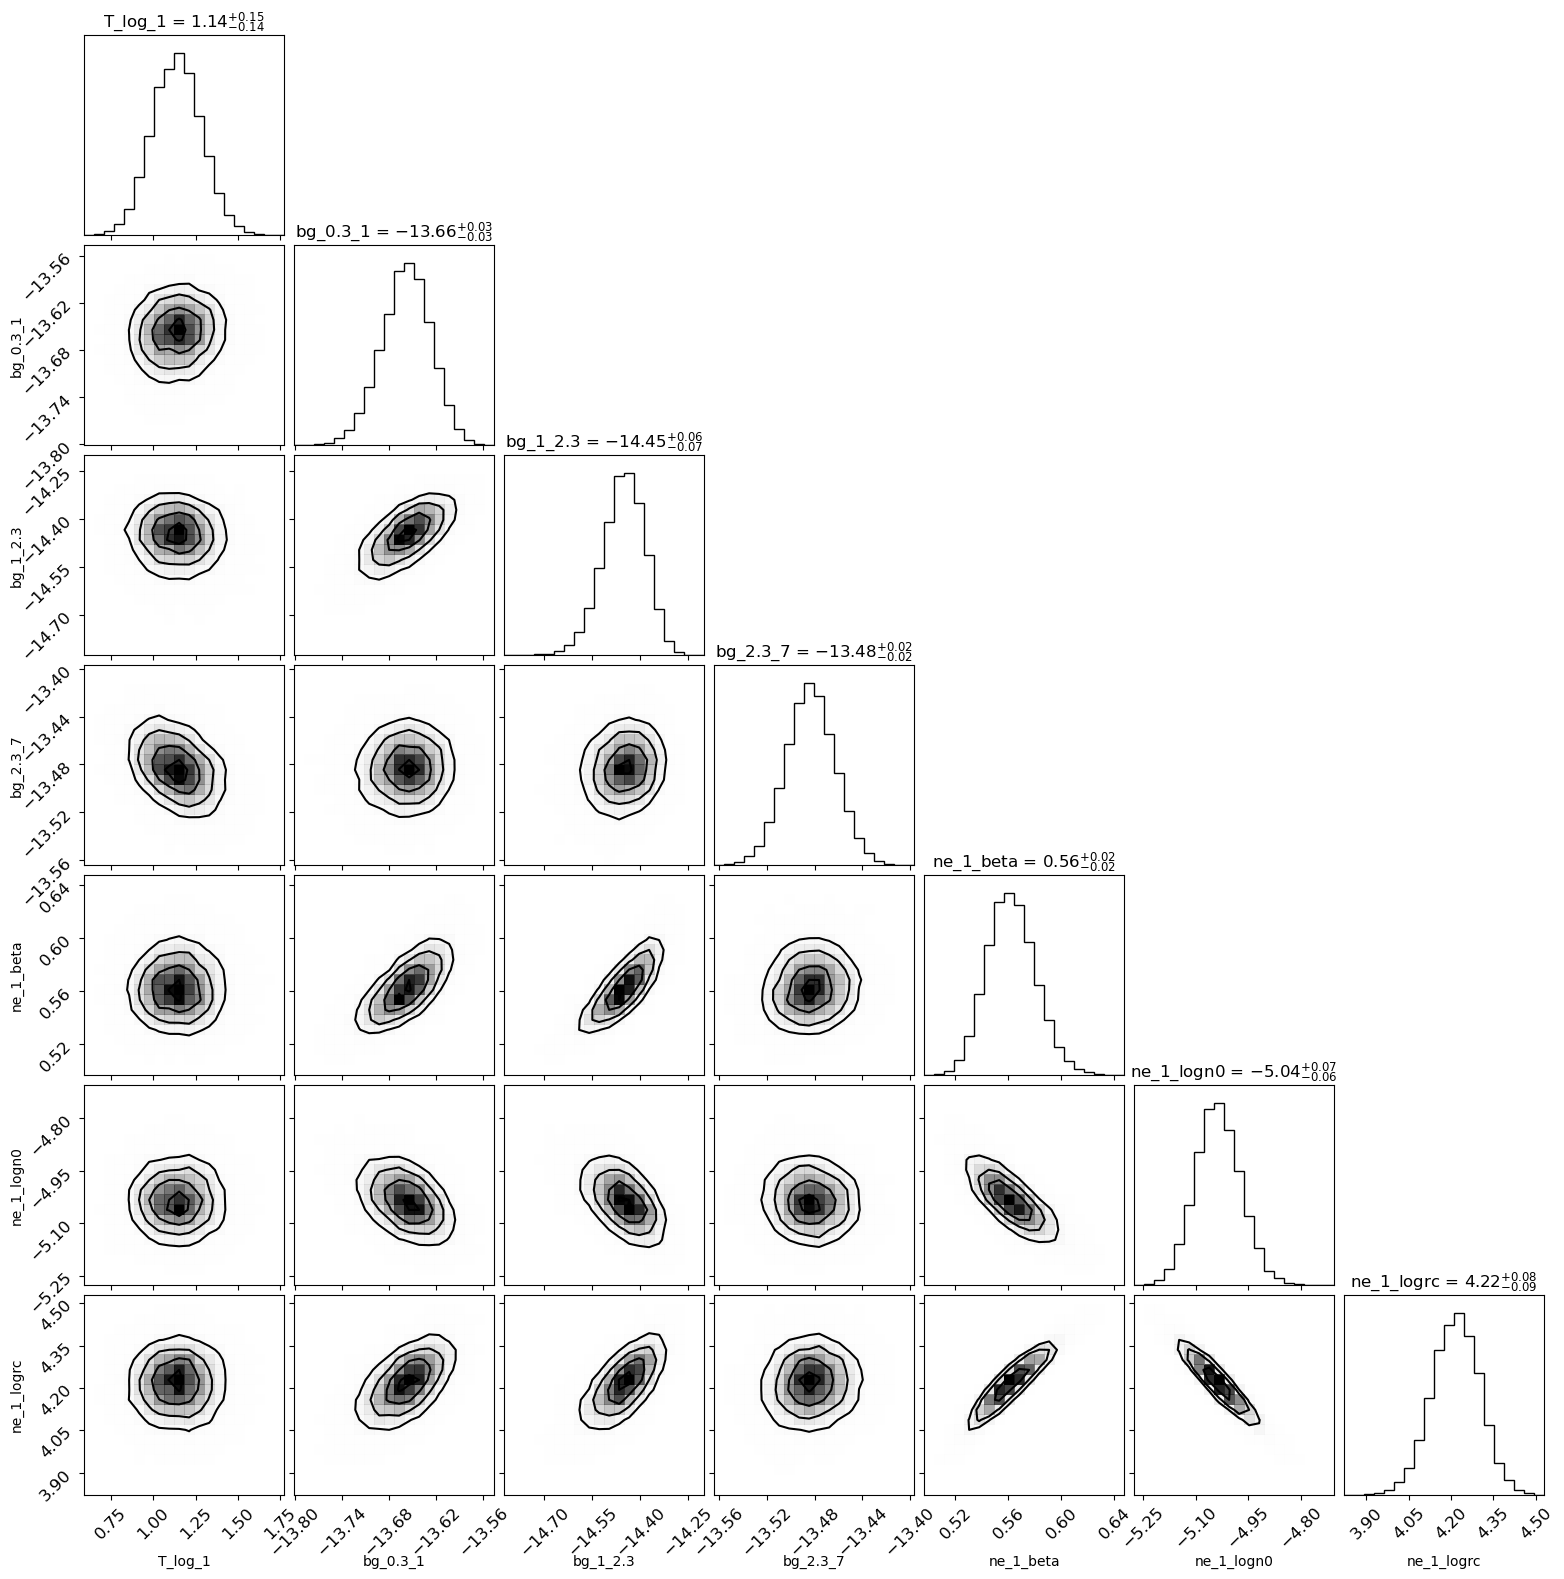

In [200]:
# fig=corner.corner(flat_data_mcmc, show_titles=True, labels=par_names, plot_datapoints=False, quantiles=(0.16, 0.84))
fig=corner.corner(flat_data_mcmc, show_titles=True, labels=par_names, plot_datapoints=False, title_quantiles=(0.16, 0.5, 0.84))
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
fig.savefig("figs/cornerplot.png")

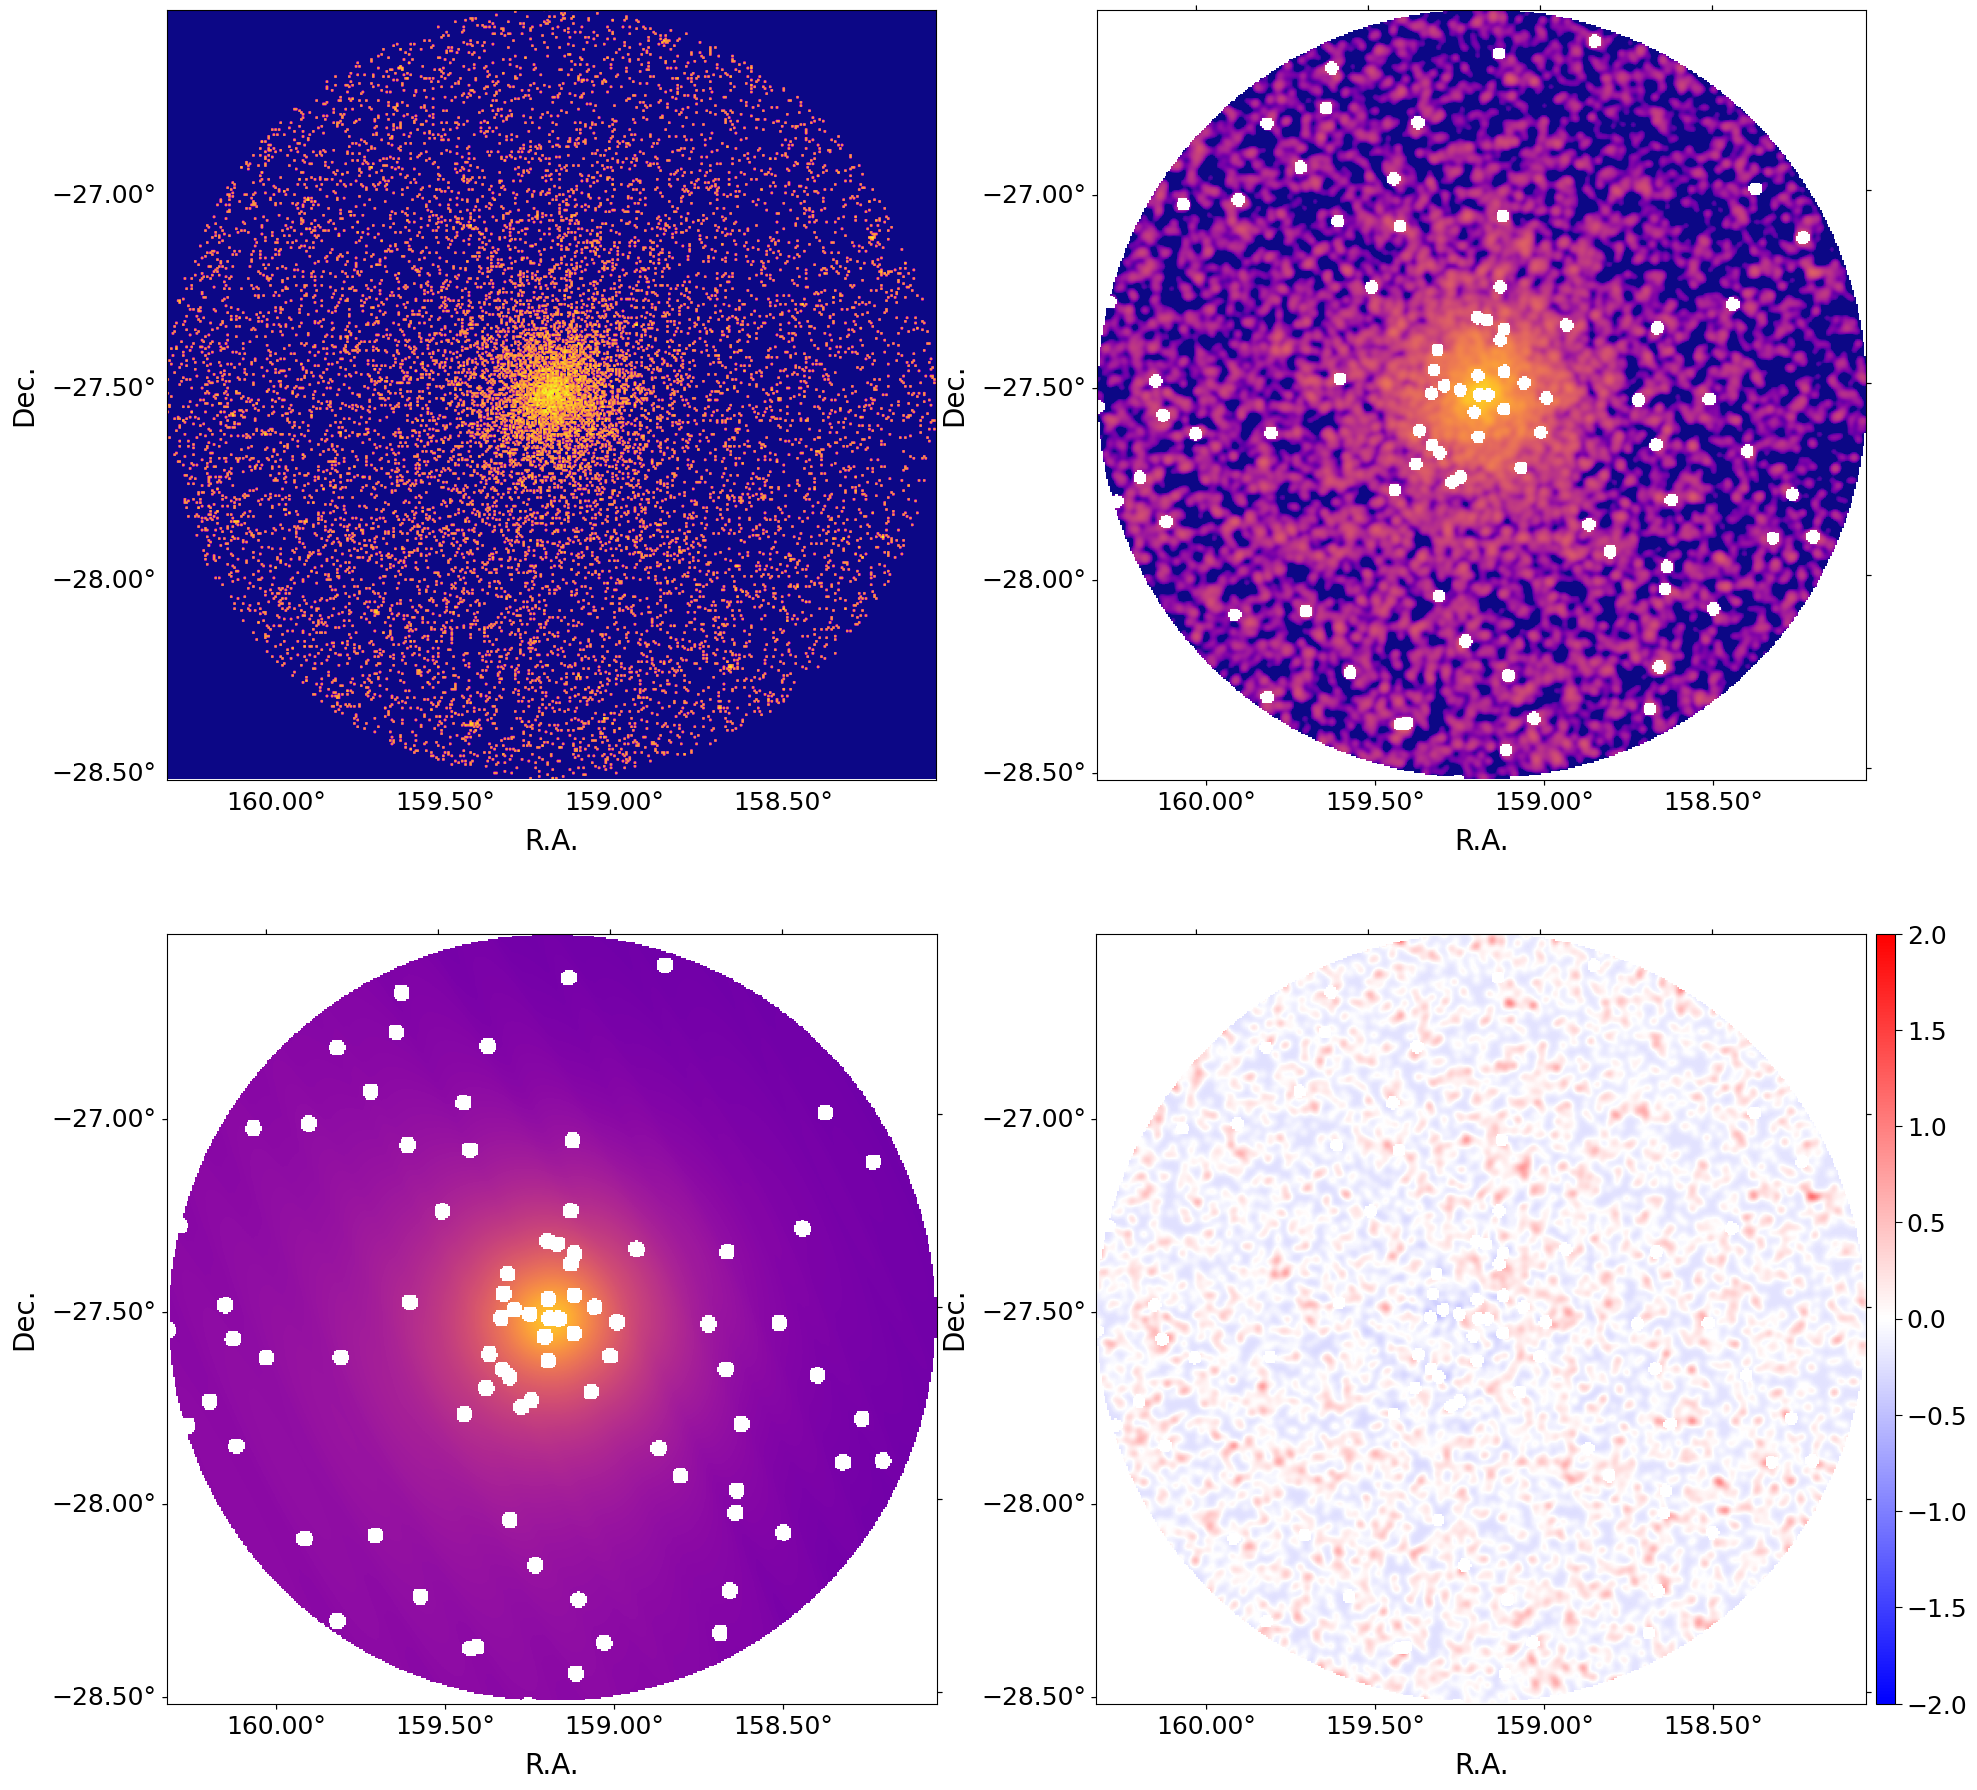

In [201]:
sb = h5py.File(sbfname, 'r')
f_mask = f"data/mask.fits.gz"
hdulist = fits.open(f_mask)
mask = hdulist[0].data
prihdr = hdulist[0].header
xsize, ysize = mask.shape
thiswcs = wcs.WCS(prihdr, relax=False)
pixsize = prihdr['CDELT2'] # degree

ima_full = np.copy(mask) * 0.0
for i in range(len(bands)):
    bandname = '%.1f_%.1f' % (bands[i][0] / 1000, bands[i][1] / 1000)
    image = f"data/ima_{bandname}.fits.gz"
    hdulist = fits.open(image)
    ima_map = hdulist[0].data
    ima_full = ima_full + ima_map

if imagebin > 1:
    ima_full = binImage(ima_full, imagebin)
    mask = binImage(mask, imagebin)
    xsize, ysize = mask.shape
    thiswcs = thiswcs.slice((np.s_[::imagebin], np.s_[::imagebin]))

model_full = np.copy(ima_full) * 0.0
for i in range(len(bands)):
    bandname = '%.1f_%.1f' % (bands[i][0] / 1000, bands[i][1] / 1000)
    bandname = bandname.replace('.0', '')
    this_model = sb[f'{bandname}_model_med'][:]
    this_model = this_model[0:ysize, 0:xsize]
    model_full = model_full + this_model

model_full[mask == 0] = np.nan

res_full = (ima_full - model_full) / np.sqrt(model_full)
res_full[mask == 0] = np.nan

gauss = Gaussian2DKernel(x_stddev=2, y_stddev=2)
res_full = convolve(res_full, gauss)
res_full[mask == 0] = np.nan

ima_full_orig = np.copy(ima_full)
ima_full = convolve(ima_full, gauss)
ima_full[mask == 0] = np.nan

fig = plt.figure(figsize=(22, 22))

ax = fig.add_subplot(221, projection=thiswcs)
ima_full_orig[(ima_full_orig == 0)] = 1e-30
# norm = simple_norm(ima_full_orig, 'log', min_cut=1e-3, max_cut=5)
norm = simple_norm(ima_full_orig, 'log', vmin=1e-3, vmax=5)
im = plt.imshow(ima_full_orig, norm=norm, cmap=plt.get_cmap('plasma'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=20)
axisdec.set_axislabel('Dec.', fontsize=20)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=18)
im.axes.tick_params(color='white', labelcolor='black')

ax = fig.add_subplot(222, projection=thiswcs)
ima_full[(ima_full == 0)] = 1e-30
# norm = simple_norm(ima_full, 'log', min_cut=3e-2, max_cut=5)
norm = simple_norm(ima_full, 'log', vmin=3e-2, vmax=5)
im = plt.imshow(ima_full, norm=norm, cmap=plt.get_cmap('plasma'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=20)
axisdec.set_axislabel('Dec.', fontsize=20)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=18)
im.axes.tick_params(color='black', labelcolor='black')

ax = fig.add_subplot(223, projection=thiswcs)
model_full = model_full.astype(np.float64)
model_full[(model_full == 0)] = 1e-30
# norm = simple_norm(model_full, 'log', min_cut=3e-2, max_cut=5)
norm = simple_norm(model_full, 'log', vmin=3e-2, vmax=5)
im = plt.imshow(model_full, norm=norm, cmap=plt.get_cmap('plasma'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=20)
axisdec.set_axislabel('Dec.', fontsize=20)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=18)
im.axes.tick_params(color='black', labelcolor='black')

ax = fig.add_subplot(224, projection=thiswcs)
# norm = simple_norm(res_full, 'linear', min_cut=-2, max_cut=2)
norm = simple_norm(res_full, 'linear', vmin=-2, vmax=2)
im = plt.imshow(res_full, norm=norm, cmap=plt.get_cmap('bwr'))
axisra = ax.coords['ra']
axisdec = ax.coords['dec']
axisra.set_axislabel('R.A.', fontsize=20)
axisdec.set_axislabel('Dec.', fontsize=20)
axisra.set_major_formatter('d.dd')
axisdec.set_major_formatter('d.dd')
ax.tick_params(axis='both', which='major', labelsize=18)
im.axes.tick_params(color='black', labelcolor='black')
axins = inset_axes(ax,
                   width="2.5%",
                   height="100%",
                   loc="lower left",
                   bbox_to_anchor=(1.012, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = plt.colorbar(im, cax=axins, orientation="vertical")
cbar.ax.tick_params(labelsize=18, length=5)

fig.savefig("figs/residual.png")

## Cluster physical properties

In [202]:
print(np.exp(1.14),np.exp(1.14-0.14),np.exp(1.14+0.15))

3.1267683651861553 2.718281828459045 3.6327865557528085


In [203]:
prof = h5py.File(physfname, 'r')
list(prof)

['H_ergpcm3',
 'H_ergpg',
 'L_bolo_ergpspcm3',
 'L_cuml_0.1_2.4_ergps',
 'L_cuml_0.2_2.3_ergps',
 'L_cuml_bolo_ergps',
 'L_proj_cuml_0.1_2.4_ergps',
 'L_proj_cuml_0.2_2.3_ergps',
 'L_proj_cuml_bolo_ergps',
 'M200_Msun',
 'M500_Msun',
 'Mdot_Msunpyr',
 'Mdot_cuml_Msunpyr',
 'Mdotpurecool_Msunpyr',
 'Mdotpurecool_cuml_Msunpyr',
 'Mgas_Msun',
 'Mgas_cuml_Msun',
 'Mtot_cuml_Msun',
 'P_ergpcm3',
 'P_keVpcm3',
 'R200_Mpc',
 'R500_Mpc',
 'S_keVcm2',
 'T_keV',
 'YX_cuml_Msun_keV',
 'Z_solar',
 'fgas_cuml',
 'flux_cuml_0.1_2.4_ergpspcm2',
 'flux_cuml_0.2_2.3_ergpspcm2',
 'flux_proj_cuml_0.1_2.4_ergpspcm2',
 'flux_proj_cuml_0.2_2.3_ergpspcm2',
 'g_cmps2',
 'ne_pcm3',
 'potential_ergpg',
 'r_arcmin',
 'r_kpc',
 'rate_NH0_proj_0.1_2.4_ps',
 'rate_NH0_proj_0.2_2.3_ps',
 'rate_proj_0.1_2.4_ps',
 'rate_proj_0.2_2.3_ps',
 'tcool_tff',
 'tcool_yr',
 'tff_yr',
 'vol_cm3']

In [204]:
r_kpc = prof['r_kpc']
r = r_kpc[:][:, 0]

ne_pcm3 = prof['ne_pcm3']
neprof = ne_pcm3[:][:, 0]
neprofl = neprof + ne_pcm3[:][:, 2]
neprofh = neprof + ne_pcm3[:][:, 1]

Mgas_cuml_Msun = prof['Mgas_cuml_Msun']
mgasprof = Mgas_cuml_Msun[:][:, 0]
mgasprofl = mgasprof + Mgas_cuml_Msun[:][:, 2]
mgasprofh = mgasprof + Mgas_cuml_Msun[:][:, 1]

L_proj_cuml = prof['L_proj_cuml_0.2_2.3_ergps']
lprof = L_proj_cuml[:][:, 0]
lprofl = lprof + L_proj_cuml[:][:, 2]
lprofh = lprof + L_proj_cuml[:][:, 1]

T_keV = prof['T_keV']
tprof = T_keV[:][:, 0]
tprofl = tprof + T_keV[:][:, 2]
tprofh = tprof + T_keV[:][:, 1]

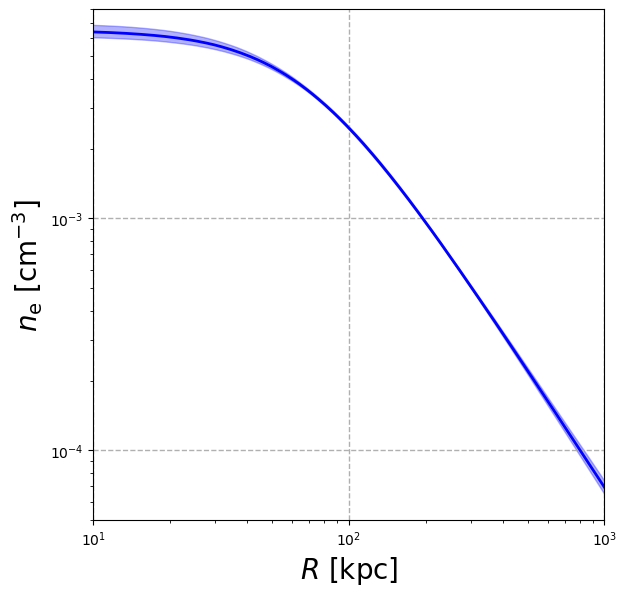

In [205]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(r, neprof, linewidth=2, color='b', label='p1')
ax.fill_between(r, neprofl, neprofh, color='b', alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10, 1000])
ax.set_ylim([5e-5, 8e-3])
ax.set_xlabel(r'$R$ [kpc]', fontsize=20)
ax.set_ylabel(r'$n_{\rm e}$ [cm$^{-3}$]', fontsize=20)
ax.grid(True)
ax.grid(linestyle='--', linewidth=1)
ax.set_position([0.16, 0.16, 0.73, 0.73])
fig.savefig('figs/neprof.png')

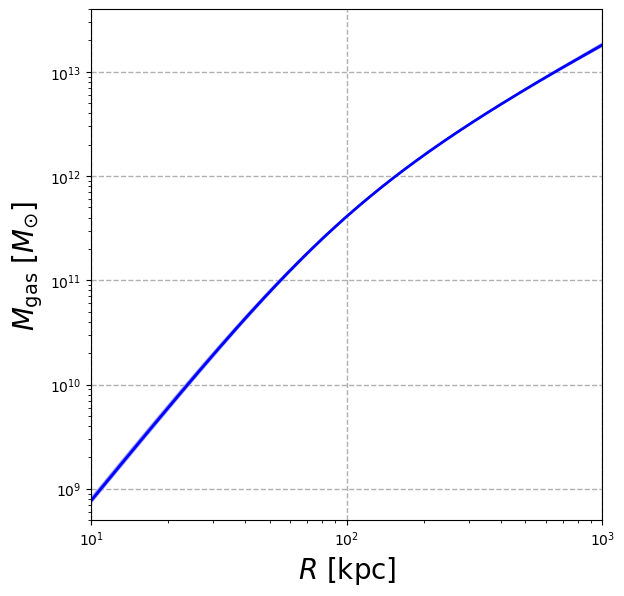

In [206]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(r, mgasprof, linewidth=2, color='b', label='p1')
ax.fill_between(r, mgasprofl, mgasprofh, color='b', alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10, 1000])
ax.set_ylim([5e8, 4e13])
ax.set_xlabel(r'$R$ [kpc]', fontsize=20)
ax.set_ylabel(r'$M_{\rm gas}$ [$M_{\odot}$]', fontsize=20)
ax.grid(True)
ax.grid(linestyle='--', linewidth=1)
ax.set_position([0.16, 0.16, 0.73, 0.73])
fig.savefig('figs/mgasprof.png')

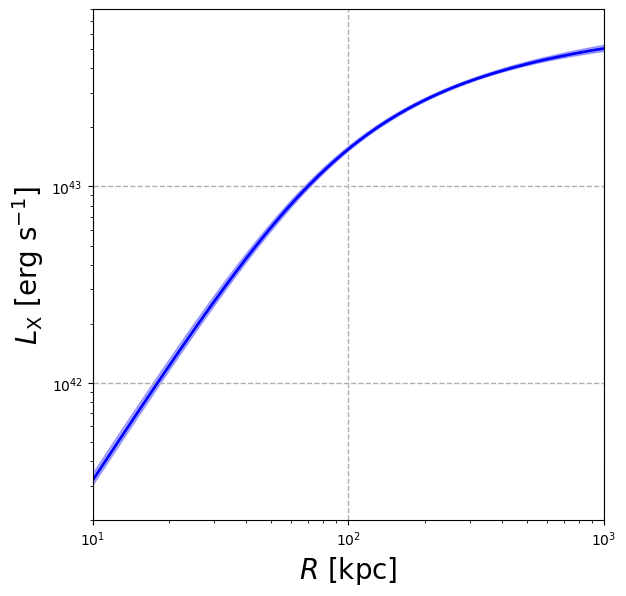

In [207]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(r, lprof, linewidth=2, color='b', label='p1')
ax.fill_between(r, lprofl, lprofh, color='b', alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10, 1000])
ax.set_ylim([2e41, 8e43])
ax.set_xlabel(r'$R$ [kpc]', fontsize=20)
ax.set_ylabel(r'$L_{\rm X}$ [erg s$^{-1}$]', fontsize=20)
ax.grid(True)
ax.grid(linestyle='--', linewidth=1)
ax.set_position([0.16, 0.16, 0.73, 0.73])
fig.savefig('figs/lprof.png')